# Phoneme Classification 音素分类
![任务](asset/task.png)

## 课题目标

zx(https://www.bilibili.com/video/BV1aX4y1o7y6/?spm_id_from=333.880.my_history.page.click&vd_source=35a8366f91f3ef012a5bcf44aaefceca)
可以参考这个视频链接，讲述一下这个任务是做什么的

## 课题数据集

zx(可以参考上面的链接或者是kaggle上对数据集的讲述)

## 数据准备

wlx（这里介绍一下class LibriDataset类的实现

## 数据预处理

wlx(这里介绍preprocess.py中的实现
补充MFCC，可以自己查一下

## 多种传统机器学习分类模型的对比和分析

### 1. 逻辑斯蒂回归

逻辑回归是一种用于解决二分类问题的机器学习算法。

In [11]:
import torch

class LogisticRegression(torch.nn.Module):
    def __init__(self,input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

首先用PyTorch实现了逻辑回归模型，通过一个线性层和sigmoid函数将输入数据转换为0到1之间的概率值，用于二分类问题的预测。

逻辑斯蒂回归本身只能用于二分类问题，如果实际情况是多分类的，那么就需要对模型进行一些改动，以下是三种比较常用的将逻辑斯蒂回归用于多分类的方法：

#### 1.1 One vs One

OvO 的方法就是将多个类别中抽出来两个类别，然后将对应的样本输入到一个逻辑斯蒂回归的模型中，学到一个对这两个类别的分类器，然后重复以上的步骤，直到所有类别两两之间都存在一个分类器。

分类器的数量=C(k, 2)，k 代表类别的数量。

本次作业实现OneVsOneLRClassifier，该模型基于逻辑回归实现了一对一的多类别分类，训练过程中对41个类别进行两两组合，以构建模型。通过BCELoss和SGD优化器进行训练，在每个组合的循环中，迭代了指定次数的epoch以训练模型。预测阶段，对于每个类别组合，生成预测概率，并根据各个组合的投票结果确定最终类别标签。最后，通过get_final_predictions函数获取最终预测结果，并将结果写入CSV文件，完成了模型的预测过程。

代码文件位于ml_classification/model/LogisticRegressionClassifier/oneVsOneLRClassifier.py

测试脚本位于ml_classification/scripts/ovoLRC.py

In [13]:
class OneVsOneLRClassifier:
    def __init__(self, input_dim, output_dim=41,random_state=None,num_epoch=50,learning_rate=1e-2):
        self.input_dim = input_dim
        self.num_classes = output_dim
        self.classifiers = {}
        self.random_state = random_state
        self.num_epoch=num_epoch
        self.learning_rate=learning_rate

    def train(self, train_data, train_labels, device):
        for i, j in combinations(range(self.num_classes), 2):
            cond = torch.logical_or(train_labels == i, train_labels == j)
            train_data_ij = train_data[cond].to(device)
            train_labels_ij = train_labels[cond].to(device)  # train_label
            model = LogisticRegression(self.input_dim).to(device)
            criterion = torch.nn.BCELoss(reduction='sum')
            optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate)

            for epoch in range(self.num_epoch):
                y_pred = model(train_data_ij)
                loss = criterion(y_pred, train_labels_ij.float().view(-1, 1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            self.classifiers[f'{i}_{j}'] = model
            print(f"Classifier for classes {i} and {j} trained.")


    #每个 predictions 都是针对一对类别的预测概率，而 results 列表包含了所有这些预测结果。
    def predict(self, test_data):
        results = []
        for i, j in combinations(range(self.num_classes), 2):
            classifier = self.classifiers[f'{i}_{j}']
            predictions = classifier(test_data)
            results.append(predictions)
        return results

    #确定最终类别的标签
    def get_final_predictions(self,results):
        final_predictions = []
        for i in range(len(results[0])):
            class_votes = Counter()
            for prediction in results:
                class_votes[prediction[i].argmax().item()] += 1
            final_predictions.append(class_votes.most_common(1)[0][0])

        return torch.tensor(final_predictions)

    def predict_and_write_to_file(self, test_loader, device, output_file='prediction.csv'):
        self.predictions = torch.tensor([])

        with torch.no_grad():
            for i, batch in enumerate(test_loader):
                features = batch.to(device)
                pred = self.get_final_predictions(self.predict(features))
                self.predictions = torch.cat((self.predictions, pred), dim=0)
                print(f"Batch {i + 1} processed.")

        with open(output_file, 'w') as f:
            f.write('Id,Class\n')
            for i, y in enumerate(self.predictions):
                f.write(f'{i},{y.item()}\n')

OvO 的方法中，当需要预测的类别变得很多的时候，那么我们需要进行训练的分类器也变得很多了，这一方面提高了训练开销，但在另一方面，每一个训练器中，因为只需要输入两个类别对应的训练样本即可，这样就又减少了开销。

从预测的角度考虑，这种方式需要运行的分类器非常多，而无法降低每个分类器的预测时间复杂度，因此预测的开销较大。

基于简单的计算可以看出该任务的分类器的个数共有C(41,2)=820，分类器个数较多，导致计算最终预测结果的时间较长。

测试集共有527364个样本，batch_size=32,测试时共需要527364/32=16480个batch

<img src="asset/ovoLRC.png" alt="ovoLRC测试情况" width="500" height="400">

发现100个batch需要花费3分钟，故16480个batch需要花费大约8个多小时，计算时间消耗太大，导致没有能够得到最终的预测结果。

#### 1.2 One vs All

OvA 的方法就是从所有类别中依次选择一个类别作为1，其他所有类别作为0，来训练分类器，因此分类器的数量要比 OvO 的数量少得多。

分类器的数量就是就是类别的数量，也就是k。

虽然分类器的数量下降了，但是对于每一个分类器来说，训练时需要将所有的训练数据全部输入进去进行训练，因此每一个分类器的训练时间复杂度是高于 OvO 的。

从预测的方面来说，因为分类器的数量较少，而每个分类器的预测时间复杂度不变，因此总体的预测时间复杂度小于 OvA。

预测结果的确定，是根据每个分类器对其对应的类别1的概率进行排序，选择概率最高的那个类别作为最终的预测类别。

本次作业实现OneVsAllLRClassifier，该模型基于逻辑回归实现了一对多的多类别分类，针对每个类别训练一个与其余类别进行对比的二元分类器。通过BCELoss和SGD优化器进行训练，在每个类别循环中，对模型进行了指定次数的epoch迭代。在预测阶段，针对每个类别的分类器，生成预测概率，最后根据概率最大值确定最终的类别标签。通过predict_and_write_to_file函数将预测结果写入CSV文件，完成了整个预测过程。
代码文件位于ml_classification/model/LogisticRegressionClassifier/oneVsAllLRClassifier.py
测试脚本位于ml_classification/scripts/ovaLRC.py

In [14]:
class OneVsAllLRClassifier:
    def __init__(self, input_dim, output_dim=41, random_state=None, num_epoch=50, learning_rate=1e-2):
        self.input_dim = input_dim
        self.num_classes = output_dim
        self.classifiers = {}
        self.random_state = random_state
        self.num_epoch = num_epoch
        self.learning_rate = learning_rate

    def train(self, train_data, train_labels, device):
        for i in range(self.num_classes):
            # Train a binary classifier for class i vs. all other classes
            cond = train_labels == i
            train_data_i = train_data.to(device)
            train_labels_i = torch.tensor(cond, dtype=torch.float).to(device)

            model = LogisticRegression(self.input_dim).to(device)
            criterion = torch.nn.BCELoss(reduction='sum')
            optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate)

            for epoch in range(self.num_epoch):
                y_pred = model(train_data_i)
                loss = criterion(y_pred, train_labels_i.view(-1, 1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            self.classifiers[str(i)] = model
            print(f"Classifier for class {i} trained.")

    def predict(self, test_data, device):
        results = torch.zeros(len(test_data), self.num_classes, dtype=torch.float).to(device)
        for i in range(self.num_classes):
            classifier = self.classifiers[str(i)]
            predictions = classifier(test_data)
            results[:, i] = predictions.squeeze()
        return results

    def predict_and_write_to_file(self, test_loader, device, output_file='prediction.csv'):
        self.predictions = torch.tensor([]).to(device)

        with torch.no_grad():
            for i, batch in enumerate(test_loader):
                features = batch.to(device)
                pred = self.predict(features, device)

                self.predictions = torch.cat((self.predictions, pred), dim=0)
                print(f"Batch {i + 1} processed.")

        with open(output_file, 'w') as f:
            f.write('Id,Class\n')
            for i, y in enumerate(self.predictions):
                class_id = torch.argmax(y).item()
                f.write(f'{i},{class_id}\n')

##### 增大每个分类器的num_epoch

由于分类器个数较多，每个分类器训练较多的epoch时间花销太高，此次实验增加每个分类器的num_epoch从5到50到500，将预测结果提交到kaggle上评测结果如下图:

<img src="asset/ovaLRC.png" alt="ovaLRC测试情况" width="1000" height="400">

与下面其他方法相比可以看出逻辑回归在这个多分类任务上表现不佳（当然现有结果还可以做超参数调优等来提高），结合本次任务，可能有以下原因：
- 特征不足或特征不明显：逻辑回归的性能通常受限于特征的质量。如果特征无法充分表达类别间的差异，模型可能无法准确分类数据。
- 类别不平衡：如果数据集中某些类别样本量远远多于其他类别，模型可能会倾向于对较多样本的类别做出良好预测，而对少样本的类别表现较差。
- 非线性关系：逻辑回归是一个线性分类器，无法捕捉复杂的非线性关系。如果数据的类别之间存在非线性关系，逻辑回归可能无法很好地拟合这种复杂关系。

#### 1.3 One-vs-All（OvA）和 One-vs-One（OvO）的对比总结

##### One-vs-All (OvA)：

###### 策略：
对于有 N 个类别的问题，OvA 策略会训练 N 个二元分类器，每个分类器负责区分一个类别与所有其他类别的区别。

例如，在一个有三个类别（A、B、C）的问题中，OvA 将训练三个二元分类器：一个用于区分 A 类别和非 A 类别，一个用于区分 B 类别和非 B 类别，另一个用于区分 C 类别和非 C 类别。

###### 训练和预测：
- 训练：对于每个类别，使用全部数据，其中该类别标记为正类（1），其他所有类别标记为负类（0）。
- 预测：当需要对新数据进行分类时，所有分类器进行预测，选择概率最高的那个作为最终分类结果。

###### 优点：
- 训练简单，只需要 N 次训练。
- 适用于大规模数据集和大量类别的问题。

##### One-vs-One (OvO)：

###### 策略：
OvO 策略会针对每一对类别组合训练一个二元分类器。

例如，在一个有三个类别（A、B、C）的问题中，OvO 将训练三个二元分类器：一个用于区分 A 和 B，一个用于区分 A 和 C，另一个用于区分 B 和 C。

###### 训练和预测：
- 训练：对于每对类别（N * (N - 1) / 2 对），只使用属于这两个类别的数据来训练一个分类器。
- 预测：当需要对新数据进行分类时，所有分类器进行预测，根据投票或其他规则确定最终分类结果。

###### 优点：
- 训练次数相对较少，仅需要 N * (N - 1) / 2 次训练。
- 在小规模数据集上可能更有效，尤其是对于某些算法而言。

##### 总结：
OvA 适合于大规模数据和大量类别的问题，而 OvO 则适合于小规模数据集和少量类别的问题。每种策略都有其独特的优势，选择哪种取决于具体的问题和数据情况。

##### 1.4 使用 softmax 函数

通过计算各个类别的概率，比较最高概率后，确定最终的类别。

对于类别互斥的情况，建议使用softmax,而不同类别之间关联性较强时，建议使用增加多个分类器的策略。

### 2. 决策树

### 3. 支持向量机

## 多种深度学习分类模型的对比和分析

### 1. MLP

BasicBlock是一个基本的神经网络模块，包含一个简单的神经网络层序列，由一个线性层（全连接层）和一个ReLU激活函数组成。这个模块的前向传播方法（forward）接受输入 x，将输入数据通过线性层和激活函数处理后输出。

In [15]:
import torch.nn as nn
class BasicBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BasicBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.block(x)
        return x

本次作业中首先实现一个simple的baseline-MLPClassifier，该模型采用多层感知器（MLP）的结构，通过BasicBlock组成的层级堆叠构建神经网络模型。该模型的前向传播方法（forward）接受输入 x，经过一系列由BasicBlock组成的隐藏层（可根据hidden_layers参数决定层数和hidden_dim参数决定每层神经元数），最终输出一个具有output_dim维度的张量，以完成多类别分类任务。

代码文件位于ml_classification/model/deepLearning/MLPClassfier.py

训练方法位于ml_classification/model/deepLearning/train.py（损失函数（CrossEntropyLoss）、优化器（Adam））

测试方法位于ml_classification/model/deepLearning/test.py

测试脚本位于ml_classification/scripts/MLP.py

In [16]:
import torch.nn as nn
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, output_dim=41, hidden_layers=1, hidden_dim=256):
        super(MLPClassifier, self).__init__()

        self.fc = nn.Sequential(
            BasicBlock(input_dim, hidden_dim),
            *[BasicBlock(hidden_dim, hidden_dim) for _ in range(hidden_layers)],
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

训练函数

模型的训练过程迭代训练数据集和验证数据集，使用交叉熵作为损失函数，Adam作为优化器。在每个 epoch 中，它对模型进行训练并记录训练集和验证集的准确率和损失值。最终，它会保存在验证集上表现最好的模型参数，并提供输出记录训练的进度和最佳准确率。

In [38]:
from torch import optim
from tqdm import tqdm
import torch
import torch.nn as nn
def train(model, train_loader, val_loader, num_epoch, learning_rate,model_path, device, writer):
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)


    best_acc = 0.0

    for epoch in range(num_epoch):
        train_acc = 0.0
        train_loss = 0.0
        val_acc = 0.0
        val_loss = 0.0

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        for i, batch in enumerate(tqdm(train_loader)):
            # A batch consists of features data and corresponding labels.
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, train_pred = torch.max(outputs, 1)
            train_acc += (train_pred.detach() == labels.detach()).sum().item()
            train_loss += loss.item()

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        with torch.no_grad():
            for i, batch in enumerate(tqdm(val_loader)):
                features, labels = batch
                features = features.to(device)
                labels = labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)

                _, val_pred = torch.max(outputs, 1)
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item()
                val_loss += loss.item()

        # Record the accuracy and lr.
        writer.add_scalar('Acc/train', train_acc / len(train_loader.dataset), epoch)
        writer.add_scalar('Acc/valid', val_acc / len(val_loader.dataset), epoch)
        writer.add_scalar('lr', optimizer.state_dict()['param_groups'][0]['lr'], epoch)

        # Print the information.
        print(
            f'[{epoch + 1:03d}/{num_epoch:03d}] Train Acc: {train_acc / len(train_loader.dataset):3.5f} Loss: {train_loss / len(train_loader):3.5f} | Val Acc: {val_acc / len(val_loader.dataset):3.5f} loss: {val_loss / len(val_loader):3.5f}')

        # If the model improves, save a checkpoint at this epoch
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f'saving model with acc {best_acc / len(val_loader.dataset):.5f}')

        print(f"{epoch + 1} lr: {optimizer.state_dict()['param_groups'][0]['lr']}")


    print(f'saving model with acc {best_acc / len(val_loader.dataset):.5f}')


# 使用示例
# train(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epoch, model_path, device, writer)

测试函数

测试函数在评估模型时，将模型设置为评估模式（eval），然后使用测试数据集进行推断，对测试数据进行迭代，获取模型输出的预测结果，并将这些结果写入指定的输出文件中，以“Id,Class”为标题，然后逐行写入测试样本的索引和模型的预测类别标签。

In [39]:
import numpy as np
import torch

def test(model, test_loader, device, output_file='result/prediction.csv'):
    model.eval()
    pred = np.array([], dtype=np.int32)

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            features = batch
            features = features.to(device)
            outputs = model(features)

            _, test_pred = torch.max(outputs, 1)
            pred = np.concatenate((pred, test_pred.cpu().numpy()), axis=0)

    with open(output_file, 'w') as f:
        f.write('Id,Class\n')
        for i, y in enumerate(pred):
            f.write('{},{}\n'.format(i, y))

#### 增加网络的隐藏层维度

固定hidden_layers=6,调整hidden_dim的值，并将预测结果提交到kaggle上评测结果如下图:

![增加网络隐藏层的对比实验](asset/dim.png)

在其他参数固定的情况下：
- concat_nframes=21
- Input dimension: 39 * concat_nframes
- Train ratio: 0.95
- Num Epoch: 15
- Learning Rate: 1e-3
- Seed: 1213
- Batch Size: 512

| hidden_layers | hidden_dim  | score  |
| ------------- | ----------- | ------ |
| 6         | 64       | 0.64314|
| -         | 128       | 0.68194|
| -       | 256          | 0.6985 |
| -     | 512          | 0.70202|
| -      | 1024         | 0.69414|

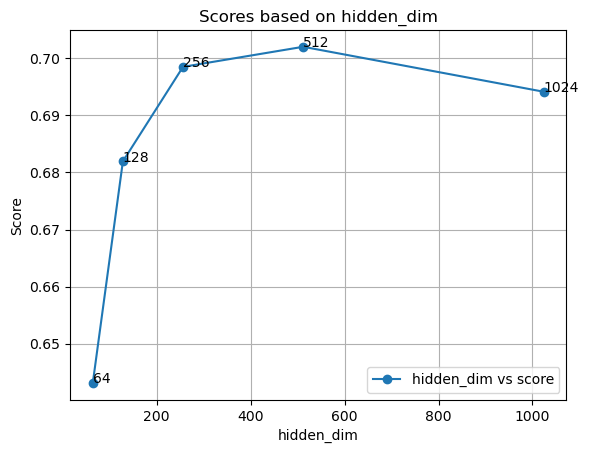

In [40]:
import matplotlib.pyplot as plt

# 假设这是您的数据
hidden_dim = [64, 128, 256, 512, 1024]
scores = [0.64314, 0.68194, 0.6985, 0.70202, 0.69414]

plt.plot(hidden_dim, scores, marker='o', label="hidden_dim vs score", linestyle='-')
plt.xlabel('hidden_dim')
plt.ylabel('Score')
plt.title('Scores based on hidden_dim')

for i, txt in enumerate(hidden_dim):
    plt.annotate(txt, (hidden_dim[i], scores[i]))

plt.legend()
plt.grid()
plt.show()

本次实验中，使用了TensorBoard记录了关于模型训练过程的数据，这有助于可视化和跟踪模型性能。

- 数据目录及设置： 设置了日志目录为 ./runs，将训练期间的损失、准确率等指标保存到该目录中。

- 启动TensorBoard： 在命令行中，通过 tensorboard --logdir=./runs 命令启动了TensorBoard，并在浏览器中输入了默认的 URL http://localhost:6006 进行访问。

- 可视化内容： 在TensorBoard界面中，我浏览了不同选项卡的内容，主要关注了 Scalars（标量）和 Graphs（图形结构）这两个标签。在 Scalars 中，我查看了损失函数和准确率随着训练步骤的变化。在 Graphs 中，我观察了模型结构和层的连接情况。

- 优点： 使用TensorBoard提供了更直观的方式来监视模型的训练过程，有助于更好地理解模型的表现。

- 终止TensorBoard服务： 在完成查看后，我使用 Ctrl + C 停止了TensorBoard服务。

TensorBoard的使用增强了对模型训练和性能评估的理解，为日后的实验提供了更便捷的监测手段。

打开TensorBoard查看训练和验证过程中增加增加网络的隐藏层维度带来的影响。

![训练](asset/dim_train.png)

![训练](asset/dim_val.png)

观察上面的结果可以发现，在神经网络中，随着隐藏层维度增加，模型的容量也增加。较大的隐藏层通常具有更多的参数，允许模型更好地拟合训练数据。因此，增加隐藏层的维度可能导致模型的表现提升，即得分提高。

然而，如果模型的容量过大，就会过度拟合训练数据，导致模型对训练数据中的噪声进行了学习，从而降低了模型对新数据的泛化能力。这可能在隐藏层维度进一步增加后表现出来，虽然模型在训练集上的得分仍在提高，但模型在验证集或测试集上的性能开始下降，即得分降低。

#### Why we  want "Deep" network,not "Fat" network?——动手试一试

##### 1.计算神经网络的参数量

先看看如何计算参数。

对于全连接层来说，其单层的参数量为 (输入维度 + 1) * 该层神经元个数。

这是因为全连接层的每个神经元都需要一个权重向量和一个偏置值来计算其输出，权重向量的长度就是输入维度，偏置值是一个标量。

若当前 network 有 hidden_layers 层 hidden layer，其中每层 hidden_layer 有 hidden_dim 维，则有：

total_params = (
    (input_dim+1) * hidden_dim +
    (hidden_dim + 1) * hidden_dim * (hidden_layers - 1) +
    (hidden_dim + 1) * output_dim
)

![全连接层](asset/mlp.png)

举例说明

In [41]:
import torch.nn as nn

input_dim = 8
hidden_dim = 16
hidden_layers = 2
output_dim = 8

# 为了简洁，舍去了 Relu()
network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # 在函数的调用中，一个 * 表示将一个序列展开为单独的位置参数，这一行代码是列表推导，最终的表现是重复生成多个 hidden layer
            *[nn.Linear(hidden_dim, hidden_dim) for _ in range(hidden_layers-1)], 
            nn.Linear(hidden_dim, output_dim)
        )
# 打印总参数量
total_params = (
    (input_dim+1) * hidden_dim +
    (hidden_dim + 1) * hidden_dim * (hidden_layers - 1) +
    (hidden_dim + 1) * output_dim
)
print(f'Total params: {total_params}')

Total params: 552


当然，实际上可以直接使用 pytorch 中的函数进行打印

In [18]:
total_params = sum(param.numel() for param in network.parameters())
print(f'Total params: {total_params}')

Total params: 552


In [19]:
for name, param in network.named_parameters():
    print(name, param.numel())

0.weight 128
0.bias 16
1.weight 256
1.bias 16
2.weight 128
2.bias 8


##### 2. 构建总参数量接近的神经网络

为了符号简便，做以下简写：
- i=input_dim
- o=output_dim
- l=hidden_layers
- d= hidden_dim

我们想对比深度神经网络和宽度神经网络，故需要在总参数量接近的情况下进行对比，那在i,o,l,d均为已知量的情况下，如果我们要在总参数量接近的情况下，将隐藏层网络层数改为: {dest_hidden_layers}，则维数应当改为多少呢？我们来设计一个函数帮助我们求解吧。

In [26]:
def get_dest_dim(input_dim, output_dim, hidden_layers, dest_hidden_layers, hidden_dim):
    '''获取目标网络隐藏层的维度（总参数量接近于原网络）'''
    # 计算一元二次方程的系数 a,b,c
    a = dest_hidden_layers - 1  # a = l_d - 1
    b = input_dim + output_dim + dest_hidden_layers  #  b = i + o + l_d
    c = - (hidden_layers - 1) * (hidden_dim ** 2) - (input_dim + output_dim + hidden_layers) * hidden_dim  # c = - (l - 1) * (d ** 2) - (i + o + l) * d
    
    # 计算分子中的平方根部分，即 b^2-4ac
    sqrt_part = (b ** 2) - 4 * a * c
    
    # 计算两个解，一个是加号，一个是减号，即(-b±√(b^2-4ac))/(2a)
    d_d_plus = (-b + sqrt_part**(0.5)) / (2 * a)
    d_d_minus = (-b - sqrt_part**(0.5)) / (2 * a)
    
    # 返回两个解的元组
    return (d_d_plus, d_d_minus)

In [27]:
concat_nframes = 21
input_dim = 39 * concat_nframes
hidden_layers = 6
hidden_dim = 512

# 设置你想要的目标网络隐藏层数量
dest_hidden_layers = 2

# 获取对应的维数
dest_hidden_dim, _ = get_dest_dim(input_dim, output_dim, hidden_layers, dest_hidden_layers, hidden_dim)
print(f"若将隐藏层网络层数改为: {dest_hidden_layers}，则维数应当改为: {round(dest_hidden_dim)}",)

若将隐藏层网络层数改为: 2，则维数应当改为: 967


对比例1：(A) 一个深窄的（隐藏层数=6，隐藏维度=512），(B) 一个浅宽的（隐藏层数=2，隐藏维度=967）。

In [28]:
concat_nframes = 21
input_dim = 39 * concat_nframes
hidden_layers = 12
hidden_dim = 1024

# 设置你想要的目标网络隐藏层数量
dest_hidden_layers = 2

# 获取对应的维数
dest_hidden_dim, _ = get_dest_dim(input_dim, output_dim, hidden_layers, dest_hidden_layers, hidden_dim)
print(f"若将隐藏层网络层数改为: {dest_hidden_layers}，则维数应当改为: {round(dest_hidden_dim)}",)

若将隐藏层网络层数改为: 2，则维数应当改为: 3130


对比例2：(A) 一个深窄的（隐藏层数=12，隐藏维度=1024），(B) 一个浅宽的（隐藏层数=2，隐藏维度=3130）。

受限于笔记本的cuda_memory，没有进行更深层的实验。

###### 对比结果和分析

将预测结果提交到kaggle上评测结果如下图:

![对比结果](asset/deep_fat.png)


| "Deep" network| score  | "Fat" network| score  |
| --------------| ------ |--------------| ------ |
|hidden_layers = 6，hidden_dim = 512| 0.70202|hidden_layers = 2，hidden_dim = 967|0.67414|
|hidden_layers = 12，hidden_dim = 1024| 0.69600|hidden_layers = 2，hidden_dim = 3130|0.68431|

分析上面的实验结果，通常来说，对于许多问题，“深度”网络通常比“宽度”网络更具优势，这是由以下一些原因所决定的：

- 表征能力： 深度网络可以更好地学习抽象和复杂的特征表示。每一层的非线性变换都有助于提取数据中的抽象特征，这有助于网络更好地理解数据。

- 泛化能力： 深度网络往往对未知数据的泛化能力更强。通过层层堆叠，网络能够更好地捕获数据中的模式，并且更少地受到局部噪声的影响。

- 计算效率： 与宽度网络相比，深度网络在参数量方面可能更有效率。更多的参数可能导致模型更容易过拟合，而深度网络能够通过分层学习更好地处理这一问题。

### 2. 双向GRU循环神经网络

### 3. LSTM长短期记忆网络